In [1]:
from argparse import Namespace
import time
import random

from my_code.data_generation import generate_tables
from my_code.blocking import run_blocking
from my_code.summarizer import Summarizer
from my_code.DK import ProductDKInjector, GeneralDKInjector
from my_code.dataset import DittoDataset
from my_code.utils import train
from my_code.utils import plot_metrics

c:\Users\DELL\anaconda3\envs\ditto_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
def run_full_pipeline(hp, config):
    trainset = config['trainset']
    validset = config['validset']
    testset = config['testset']
    random.seed(42)  # For reproducibility
    
    run_blocking(hp)
    if hp.summarize:
        summarizer = Summarizer(config, hp.lm)
        trainset = summarizer.transform_file(trainset, max_len = hp.max_len, overwrite=hp.overwrite)
        testset = summarizer.transform_file(testset, max_len = hp.max_len, overwrite=hp.overwrite)
        validset = summarizer.transform_file(validset, max_len = hp.max_len, overwrite=hp.overwrite)

    if hp.dk is not None:
        if hp.dk == 'product':
            injector = ProductDKInjector(config, hp.dk)
        else:
            injector = GeneralDKInjector(config, hp.dk)
        
        trainset = injector.transform_file(trainset, overwrite=hp.overwrite)
        validset = injector.transform_file(validset, overwrite=hp.overwrite)
        testset = injector.transform_file(testset, overwrite=hp.overwrite)

    train_dataset = DittoDataset(trainset,
                                   lm=hp.lm,
                                   max_len=hp.max_len,
                                   size=hp.size,
                                   da=hp.da)
    valid_dataset = DittoDataset(validset, lm=hp.lm)
    test_dataset = DittoDataset(testset, lm=hp.lm)

    t1 = time.time()
    csv_log_path = train(train_dataset, valid_dataset, test_dataset, run_tag="test_run", hp=hp)
    t2 = time.time()

    print(f"Training time: {round(t2-t1, 3)} seconds")
    plot_metrics(csv_log_path)

In [3]:
def main(hp, config):
    #---------------------------------------------------------------------------------------------
    #TO UPDATE IF NEEDED FOR DATA GENERATION
    if hp.task == "Generated_data":
        generate_tables(base_path=hp.base_path_blocking, n_total=100, match_ratio=0.3)
    #---------------------------------------------------------------------------------------------
    #If the data already exist make sure to add the task name to configs and also use it hp.task and put the data in base_path_blocking/data/{task_name}   (reference and source)
    run_full_pipeline(hp, config)

In [4]:
# ---------------------------------------------------------------------------------------------
# TO UPDATE TO THE PROJECT ROOT
base_path_blocking = "D:/Study/ENSIAS/stage_2/ER/ditto/resultat"
task = "Generated_data"
# ---------------------------------------------------------------------------------------------

hp = Namespace(
    # Hyperparameters for blocking part
    model_name_blocking="all-MiniLM-L12-v2",
    top_k_blocking=5,
    threshold_blocking=0.95,
    batch_size_blocking=512,

    # Paths
    base_path_blocking=base_path_blocking,

    # Input CSVs
    table_reference_csv=f"{base_path_blocking}/data/{task}/reference_table.csv",
    table_source_csv=f"{base_path_blocking}/data/{task}/source_table.csv",
    ground_truth_csv=f"{base_path_blocking}/data/{task}/ground_truth.csv",

    # Ditto-style TXT
    table_reference_txt=f"{base_path_blocking}/input_txt_blocking/{task}/reference_table.txt",
    table_source_txt=f"{base_path_blocking}/input_txt_blocking/{task}/source_table.txt",

    # Vector files
    table_reference_vec=f"{base_path_blocking}/vectors_blocking/{task}/reference_table.txt.mat",
    table_source_vec=f"{base_path_blocking}/vectors_blocking/{task}/source_table.txt.mat",

    # Blocking outputs
    output_pairs_csv=f"{base_path_blocking}/blocking/{task}/blocking_pairs.csv",
    output_ditto_txt=f"{base_path_blocking}/blocking/{task}/blocking_pairs_ditto.txt",

    # Inference output
    output_inference_csv=f"{base_path_blocking}/inference/{task}/result.csv",

    dataset_csv_dir=f"{base_path_blocking}/dataset_ditto_csv",
    dataset_txt_dir=f"{base_path_blocking}/dataset_ditto_txt",

    # Logging and task info
    logdir="./logs",
    task=task,

    # Hyperparameters for training
    batch_size=32,
    lr=3e-5,
    epochs=5,
    save_model=True,
    lm="distilbert",
    size=None,
    alpha_aug=0.8,
    max_len=256,
    da="all",
    summarize=True,
    dk=True,
    fp16=True,
    overwrite=True
)

configs = [{
    "name": "Generated_data",
    "trainset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/train.txt",
    "validset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/valid.txt",
    "testset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/test.txt"
},
{
    "name": "data_1",
    "trainset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/train.txt",
    "validset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/valid.txt",
    "testset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/test.txt"
}
]

configs = {conf['name'] : conf for conf in configs}
config = configs[hp.task]

Generating 100 records:
30 matching pairs (30%)
70 non-matching records

📁 Files saved
 - Reference: 30 rows
 - Source:    100 rows
 - Ground Truth: 90 pairs
   - Matches: 30
   - Non-matches: 60


c:\Users\DELL\anaconda3\envs\ditto_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\ditto_env\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 1/1 [00:00<00:00, 341.39it/s]



📊 Blocking Metrics:
 - Total candidate pairs generated: 500
 - Total true matches in ground truth: 30
 - Predicted positive pairs (label=1): 24
 - Correctly predicted matches: 23
 - Recall:           0.7667
 - Precision:        0.9583
 - Reduction Ratio:  0.8333

✅ Blocking completed: 48 balanced pairs written to:

📁 Split saved


Training:   0%|          | 0/1 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1
  Time: 14.22 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 2
  Time: 16.98 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 3
  Time: 20.03 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 4
  Time: 21.25 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 5
  Time: 20.96 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667
Training time: 95.154 seconds


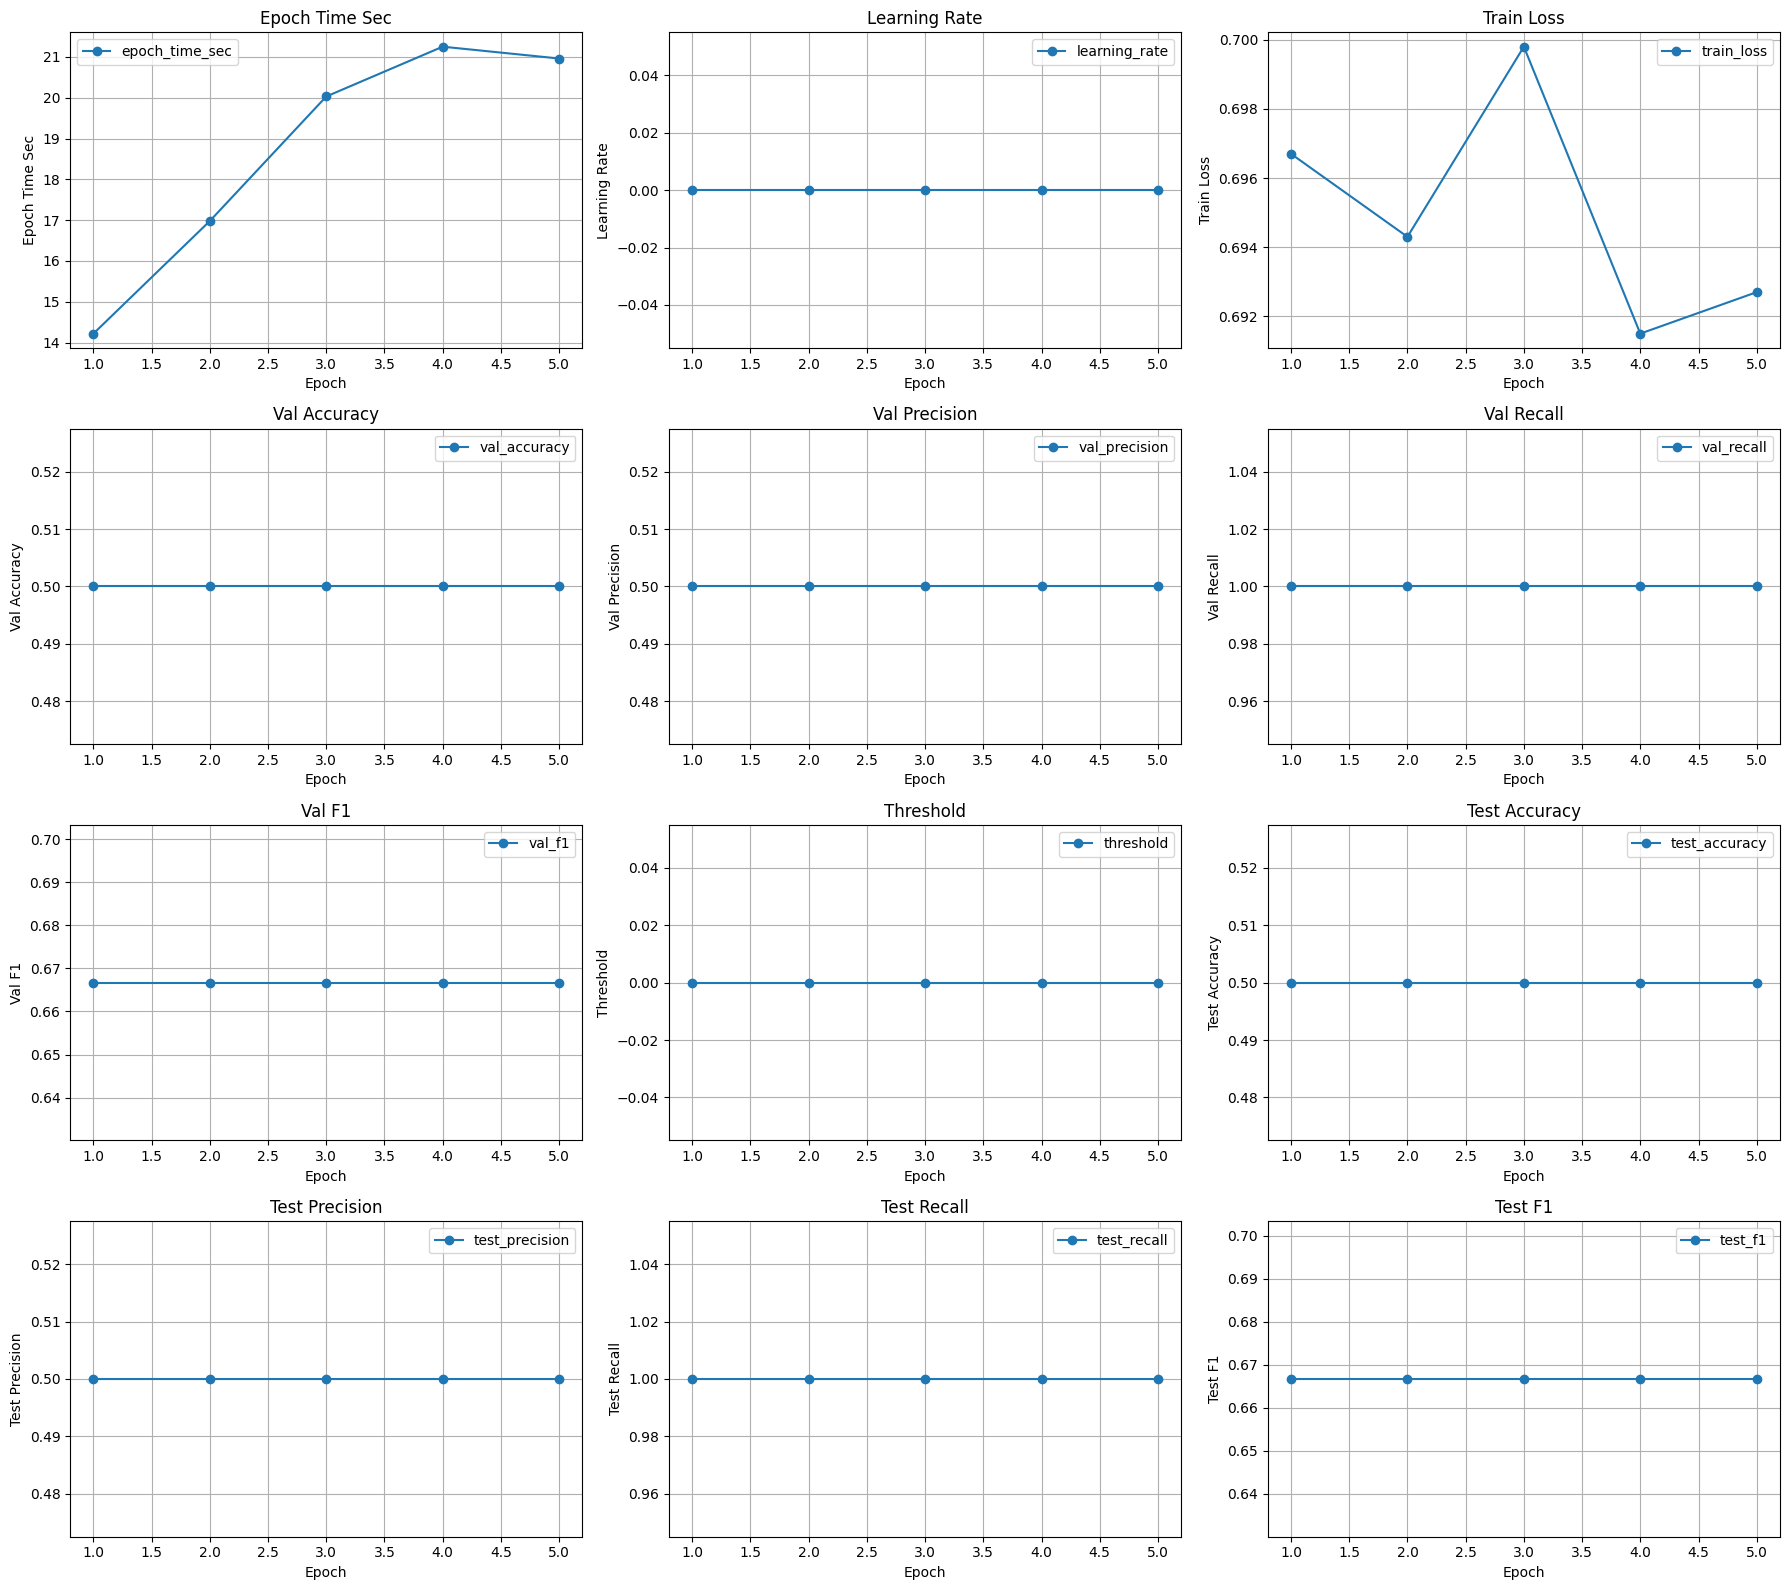

In [5]:
main(hp, config)

In [6]:
# ---------------------------------------------------------------------------------------------
# TO UPDATE TO THE PROJECT ROOT
base_path_blocking = "D:/Study/ENSIAS/stage_2/ER/ditto/resultat"
task = "data_1"
# ---------------------------------------------------------------------------------------------

hp = Namespace(
    # Hyperparameters for blocking part
    model_name_blocking="all-MiniLM-L12-v2",
    top_k_blocking=5,
    threshold_blocking=0.95,
    batch_size_blocking=512,

    # Paths
    base_path_blocking=base_path_blocking,

    # Input CSVs
    table_reference_csv=f"{base_path_blocking}/data/{task}/reference_table.csv",
    table_source_csv=f"{base_path_blocking}/data/{task}/source_table.csv",
    ground_truth_csv=f"{base_path_blocking}/data/{task}/ground_truth.csv",

    # Ditto-style TXT
    table_reference_txt=f"{base_path_blocking}/input_txt_blocking/{task}/reference_table.txt",
    table_source_txt=f"{base_path_blocking}/input_txt_blocking/{task}/source_table.txt",

    # Vector files
    table_reference_vec=f"{base_path_blocking}/vectors_blocking/{task}/reference_table.txt.mat",
    table_source_vec=f"{base_path_blocking}/vectors_blocking/{task}/source_table.txt.mat",

    # Blocking outputs
    output_pairs_csv=f"{base_path_blocking}/blocking/{task}/blocking_pairs.csv",
    output_ditto_txt=f"{base_path_blocking}/blocking/{task}/blocking_pairs_ditto.txt",

    # Inference output
    output_inference_csv=f"{base_path_blocking}/inference/{task}/result.csv",

    dataset_csv_dir=f"{base_path_blocking}/dataset_ditto_csv",
    dataset_txt_dir=f"{base_path_blocking}/dataset_ditto_txt",

    # Logging and task info
    logdir="./logs",
    task=task,

    # Hyperparameters for training
    batch_size=32,
    lr=3e-5,
    epochs=5,
    save_model=True,
    lm="distilbert",
    size=None,
    alpha_aug=0.8,
    max_len=256,
    da="all",
    summarize=True,
    dk=True,
    fp16=True,
    overwrite=True
)

configs = [{
    "name": "Generated_data",
    "trainset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/train.txt",
    "validset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/valid.txt",
    "testset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/test.txt"
},
{
    "name": "data_1",
    "trainset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/train.txt",
    "validset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/valid.txt",
    "testset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/test.txt"
}
]

configs = {conf['name'] : conf for conf in configs}
config = configs[hp.task]

c:\Users\DELL\anaconda3\envs\ditto_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 255.55it/s]



✅ Blocking completed: 48 balanced pairs written to:

📁 Split saved


Epoch 1
  Time: 22.02 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 2
  Time: 16.73 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 3
  Time: 17.01 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 4
  Time: 16.90 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 5
  Time: 16.51 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667
Training time: 94.677 seconds


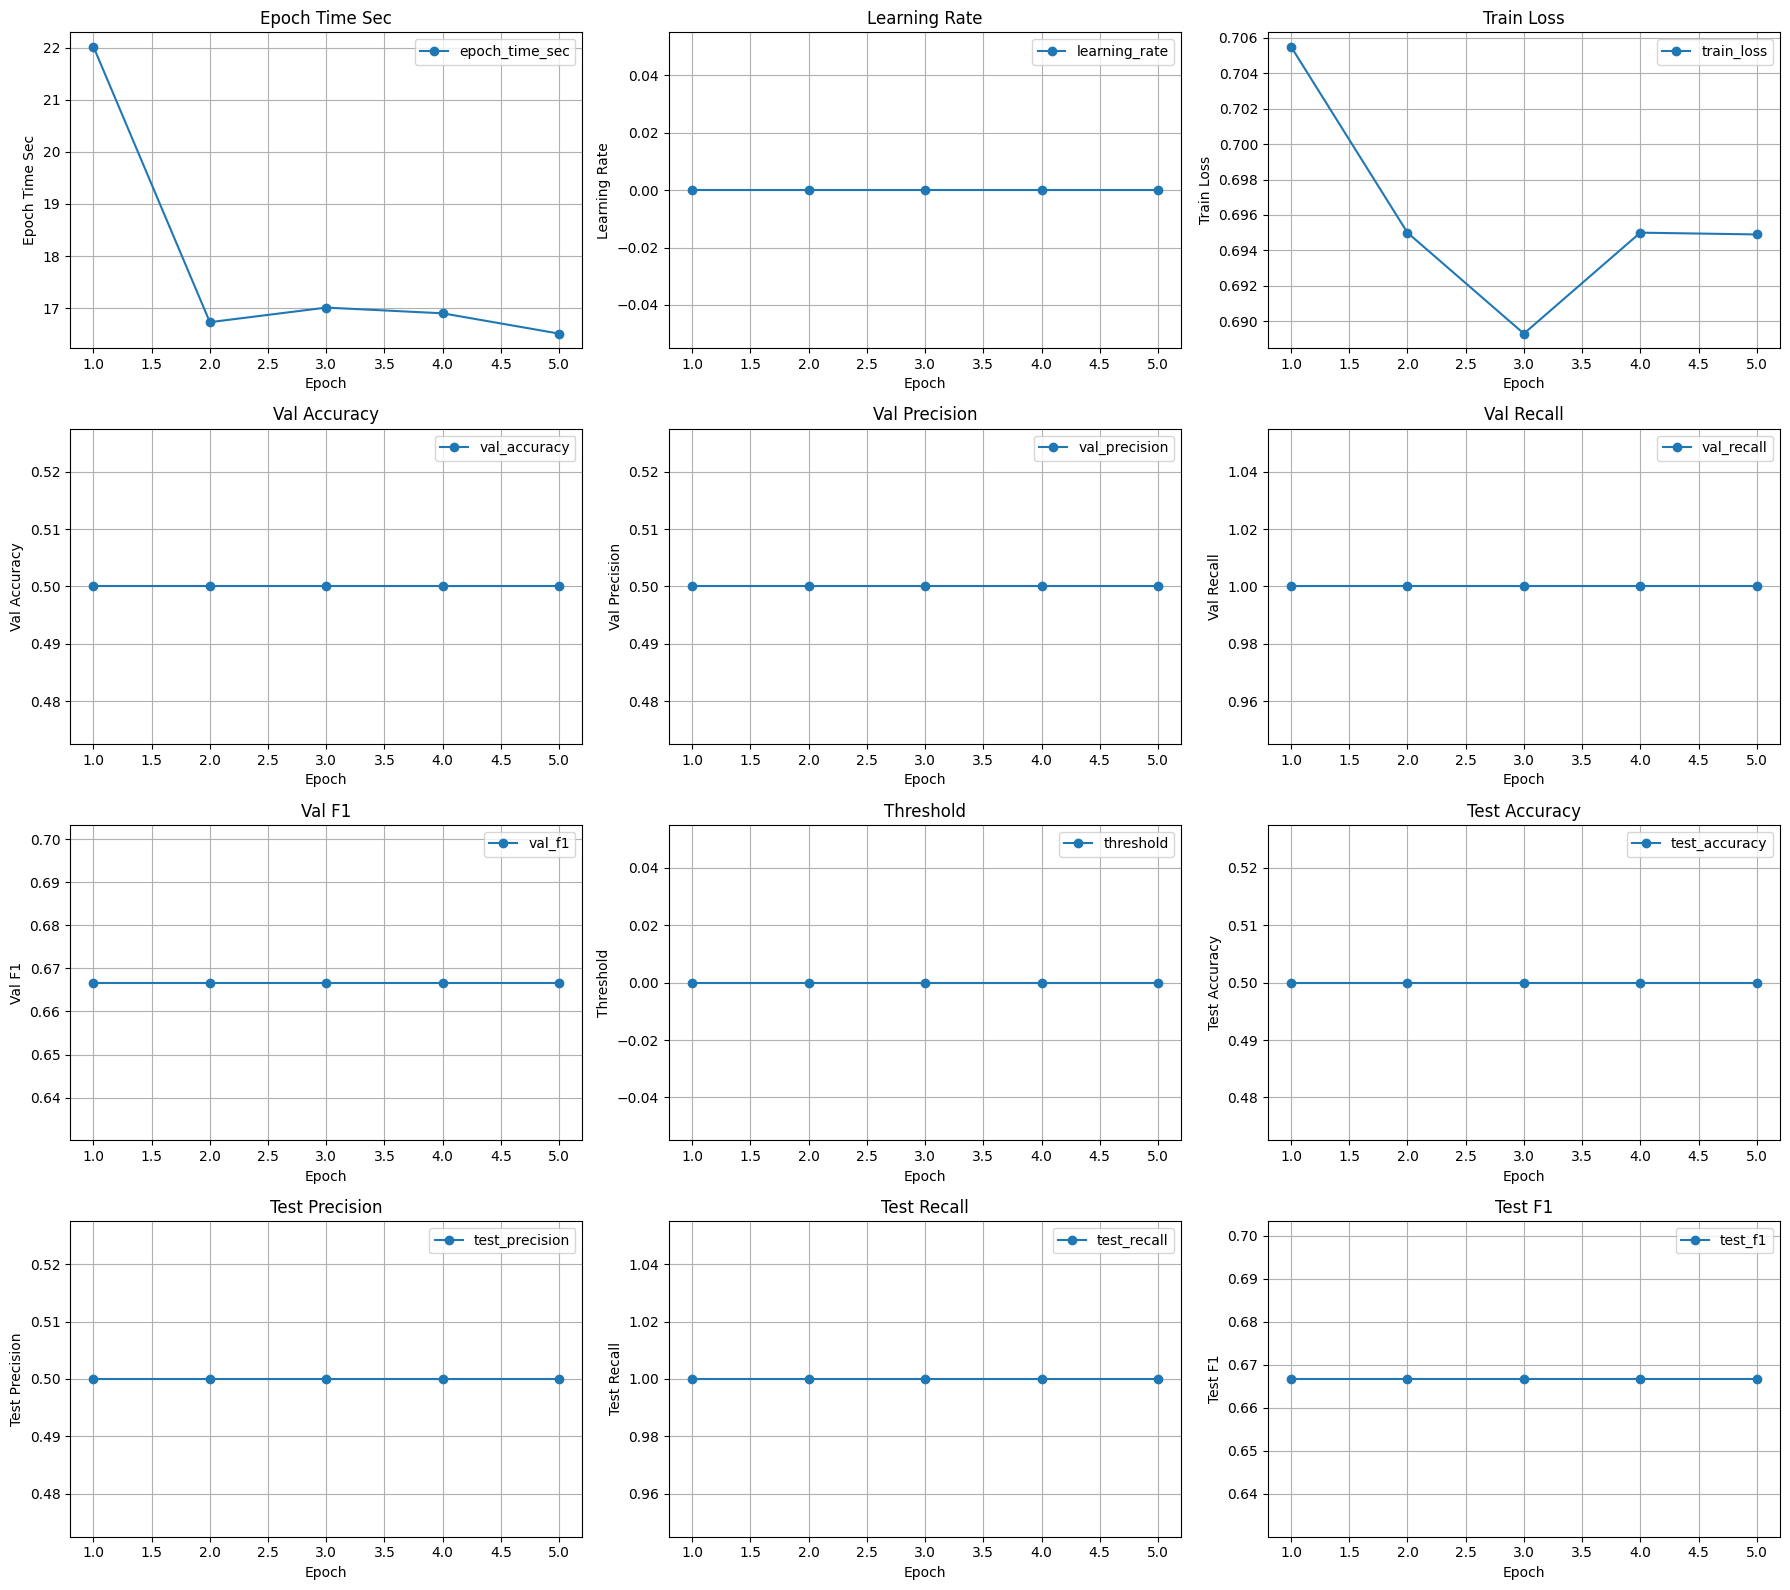

In [7]:
main(hp, config)

In [8]:
# ---------------------------------------------------------------------------------------------
# TO UPDATE TO THE PROJECT ROOT
base_path_blocking = "D:/Study/ENSIAS/stage_2/ER/ditto/resultat"
task = "data_1"
# ---------------------------------------------------------------------------------------------

hp = Namespace(
    # Hyperparameters for blocking part
    model_name_blocking="all-MiniLM-L12-v2",
    top_k_blocking=5,
    threshold_blocking=0.95,
    batch_size_blocking=512,

    # Paths
    base_path_blocking=base_path_blocking,

    # Input CSVs
    table_reference_csv=f"{base_path_blocking}/data/{task}/reference_table.csv",
    table_source_csv=f"{base_path_blocking}/data/{task}/source_table.csv",
    ground_truth_csv=f"{base_path_blocking}/data/{task}/ground_truth.csv",

    # Ditto-style TXT
    table_reference_txt=f"{base_path_blocking}/input_txt_blocking/{task}/reference_table.txt",
    table_source_txt=f"{base_path_blocking}/input_txt_blocking/{task}/source_table.txt",

    # Vector files
    table_reference_vec=f"{base_path_blocking}/vectors_blocking/{task}/reference_table.txt.mat",
    table_source_vec=f"{base_path_blocking}/vectors_blocking/{task}/source_table.txt.mat",

    # Blocking outputs
    output_pairs_csv=f"{base_path_blocking}/blocking/{task}/blocking_pairs.csv",
    output_ditto_txt=f"{base_path_blocking}/blocking/{task}/blocking_pairs_ditto.txt",

    # Inference output
    output_inference_csv=f"{base_path_blocking}/inference/{task}/result.csv",

    dataset_csv_dir=f"{base_path_blocking}/dataset_ditto_csv",
    dataset_txt_dir=f"{base_path_blocking}/dataset_ditto_txt",

    # Logging and task info
    logdir="./logs",
    task=task,

    # Hyperparameters for training
    batch_size=16,
    lr=3e-5,
    epochs=5,
    save_model=True,
    lm="distilbert",
    size=None,
    alpha_aug=0.8,
    max_len=256,
    da="all",
    summarize=True,
    dk=True,
    fp16=True,
    overwrite=True
)

configs = [{
    "name": "Generated_data",
    "trainset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/train.txt",
    "validset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/valid.txt",
    "testset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/test.txt"
},
{
    "name": "data_1",
    "trainset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/train.txt",
    "validset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/valid.txt",
    "testset": f"{hp.base_path_blocking}/dataset_ditto_txt/{hp.task}/test.txt"
}
]

configs = {conf['name'] : conf for conf in configs}
config = configs[hp.task]

c:\Users\DELL\anaconda3\envs\ditto_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 341.58it/s]



✅ Blocking completed: 48 balanced pairs written to:

📁 Split saved


Epoch 1
  Time: 13.05 seconds
  Learning Rate: 0.00001800
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 2
  Time: 13.11 seconds
  Learning Rate: 0.00000600
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 3
  Time: 12.72 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 4
  Time: 12.53 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667


Epoch 5
  Time: 13.11 seconds
  Learning Rate: 0.00000000
  Validation F1: 0.6667 | Threshold: 0.00
  Validation Accuracy: 0.5000
  Validation Precision: 0.5000
  Validation Recall: 1.0000
  Test Accuracy: 0.5000
  Test Precision: 0.5000
  Test Recall: 1.0000
  Test F1 Score: 0.6667 | Best F1 so far: 0.6667
Training time: 67.225 seconds


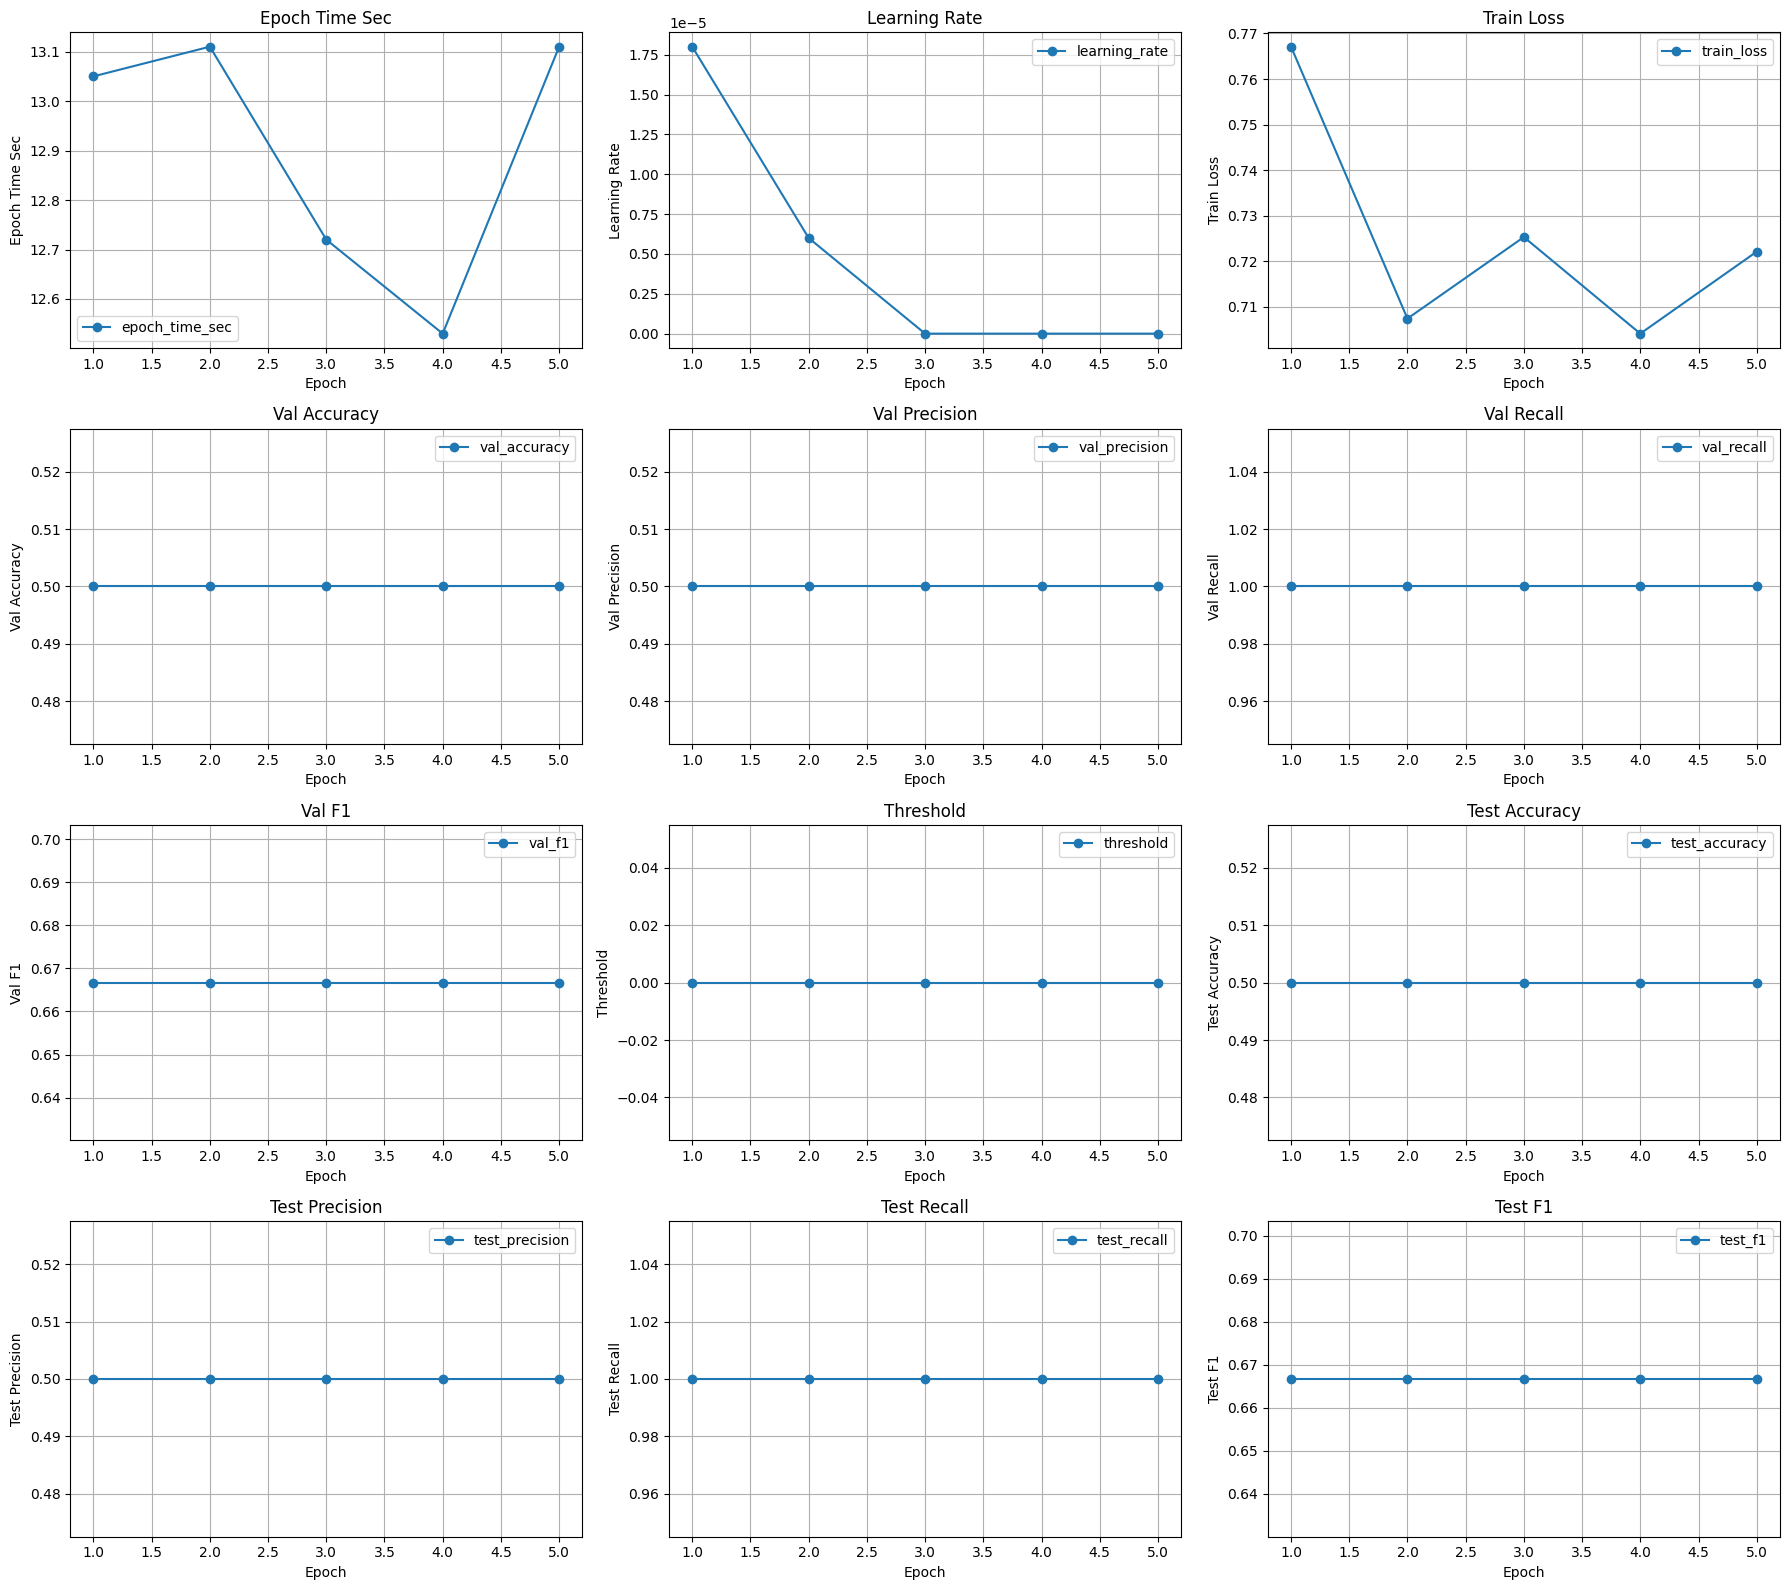

In [9]:
main(hp, config)